## ATAC + MULTIOME (males)

### Label transfer with Seurat 

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_april2021/figures_males/'

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
import anndata2ri
anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

**Load data**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_apr2021/"
experiment_prefix = 'males_'

Try to use the gene accessibility scores computed with Emma's method and integrate with matched scRNAseq samples annotated by Luz 

In [9]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
table(ATAC_geneScores@meta.data$individual)

[1] 1061 2822 3383 8302 4372 5143 5193


In [78]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE)
RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
table(RNAseq@meta.data$individual)

[1] 3657 5293  968 6115 3391 7118 4665


In [79]:
%%R -i RNAseq

print(table(RNAseq@meta.data$annotated_clusters)) 


Endothelial  Epithelial   Erythroid FetalLeydig  Germ cells          Gi 
       1346        1064        1521         785         901        2501 
     Immune      M_ALX1       M_MGP M_prog_ISL1      Neural          PV 
       1096         466        5088        1278        1461         683 
    Sertoli          Ti     coelEpi      sKITLG       sLGR5       sPAX8 
       8396        3504         352         148         258         359 


**Try label transfer with major cluster annotations**

In [80]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:26, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$annotated_clusters, dims = 1:26, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [81]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [82]:
predicted_probabilities

,Immune,Sertoli,Germ cells,Erythroid,Ti,FetalLeydig,Epithelial,M-MGP,Gi,PV,Endothelial,sPAX8,coelEpi,M-ALX1,Neural,M-prog-ISL1,sKITLG,sLGR5,max
01-AAACGAAAGCTGAGGT-1,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
01-AAACGAACAATCATCG-1,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
01-AAACTCGTCACCCGGA-1,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
01-AAACTGCCAAGGGTAC-1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.092064,0.000000,0.000000,0.000000,0.0,0.76919,0.138746,0.000000,0.0,0.0,0.0,0.0,0.769190
01-AAACTGCGTGAATGTA-1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.940789,0.000000,0.042563,0.0,0.00000,0.000000,0.016648,0.0,0.0,0.0,0.0,0.940789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09-TTTGTGGCATCCATCT-1,0.0,0.0,0.0,0.0,0.327863,0.000000,0.000000,0.151634,0.520504,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.520504
09-TTTGTGGCATGTTGGC-1,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
09-TTTGTGTTCCCTGATC-1,0.0,0.0,0.0,0.0,0.609552,0.347996,0.000000,0.011442,0.031011,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.609552
09-TTTGTGTTCGAAGTAG-1,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000


In [83]:
predicted_probabilities.columns

Index(['Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig',
       'Epithelial', 'M-MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'coelEpi',
       'M-ALX1', 'Neural', 'M-prog-ISL1', 'sKITLG', 'sLGR5', 'max'],
      dtype='object')

Replace dashes with underscores as stupid R changes them

In [84]:
predicted_probabilities.columns = ['Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig',
       'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8',
        'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG',
       'sLGR5', 'max']

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [85]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")
gene_data

AnnData object with n_obs × n_vars = 30276 × 22236
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'Sertoli_WFDC2', 'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5', 'max', 'mean_gene_activity'
    var: 'gene_id'
    uns: 'individual_colors', 'neighbors', 'sample_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_28', 'X_umap'
    obsp: 'connectivities', 'distances'

In [86]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

Immune
Sertoli
Germ cells
Erythroid
Ti
FetalLeydig
Epithelial
M_MGP
Gi
PV
Endothelial
sPAX8
coelEpi
M_ALX1
Neural
M_prog_ISL1
sKITLG
sLGR5
max


In [9]:
gonads_colors = ['#c466b0','#e64e74',  '#60bddb', '#edb7b7', '#779eed', '#7b9e99',  '#70ccbe', 
               '#7b9e99', '#91bd80', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
               '#e08b8b', '#edb7b7', '#d9abb7','#aad3f2', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb']

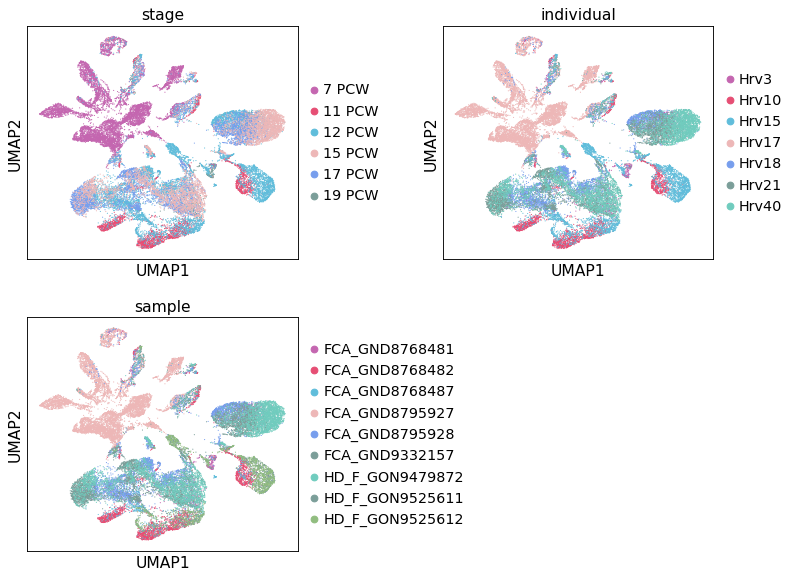

In [88]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "_noharmony_male.pdf")

In [89]:
gene_data.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage',
       'individual', 'Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti',
       'FetalLeydig', 'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial',
       'sPAX8', 'Sertoli_WFDC2', 'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1',
       'sKITLG', 'sLGR5', 'max', 'mean_gene_activity'],
      dtype='object')

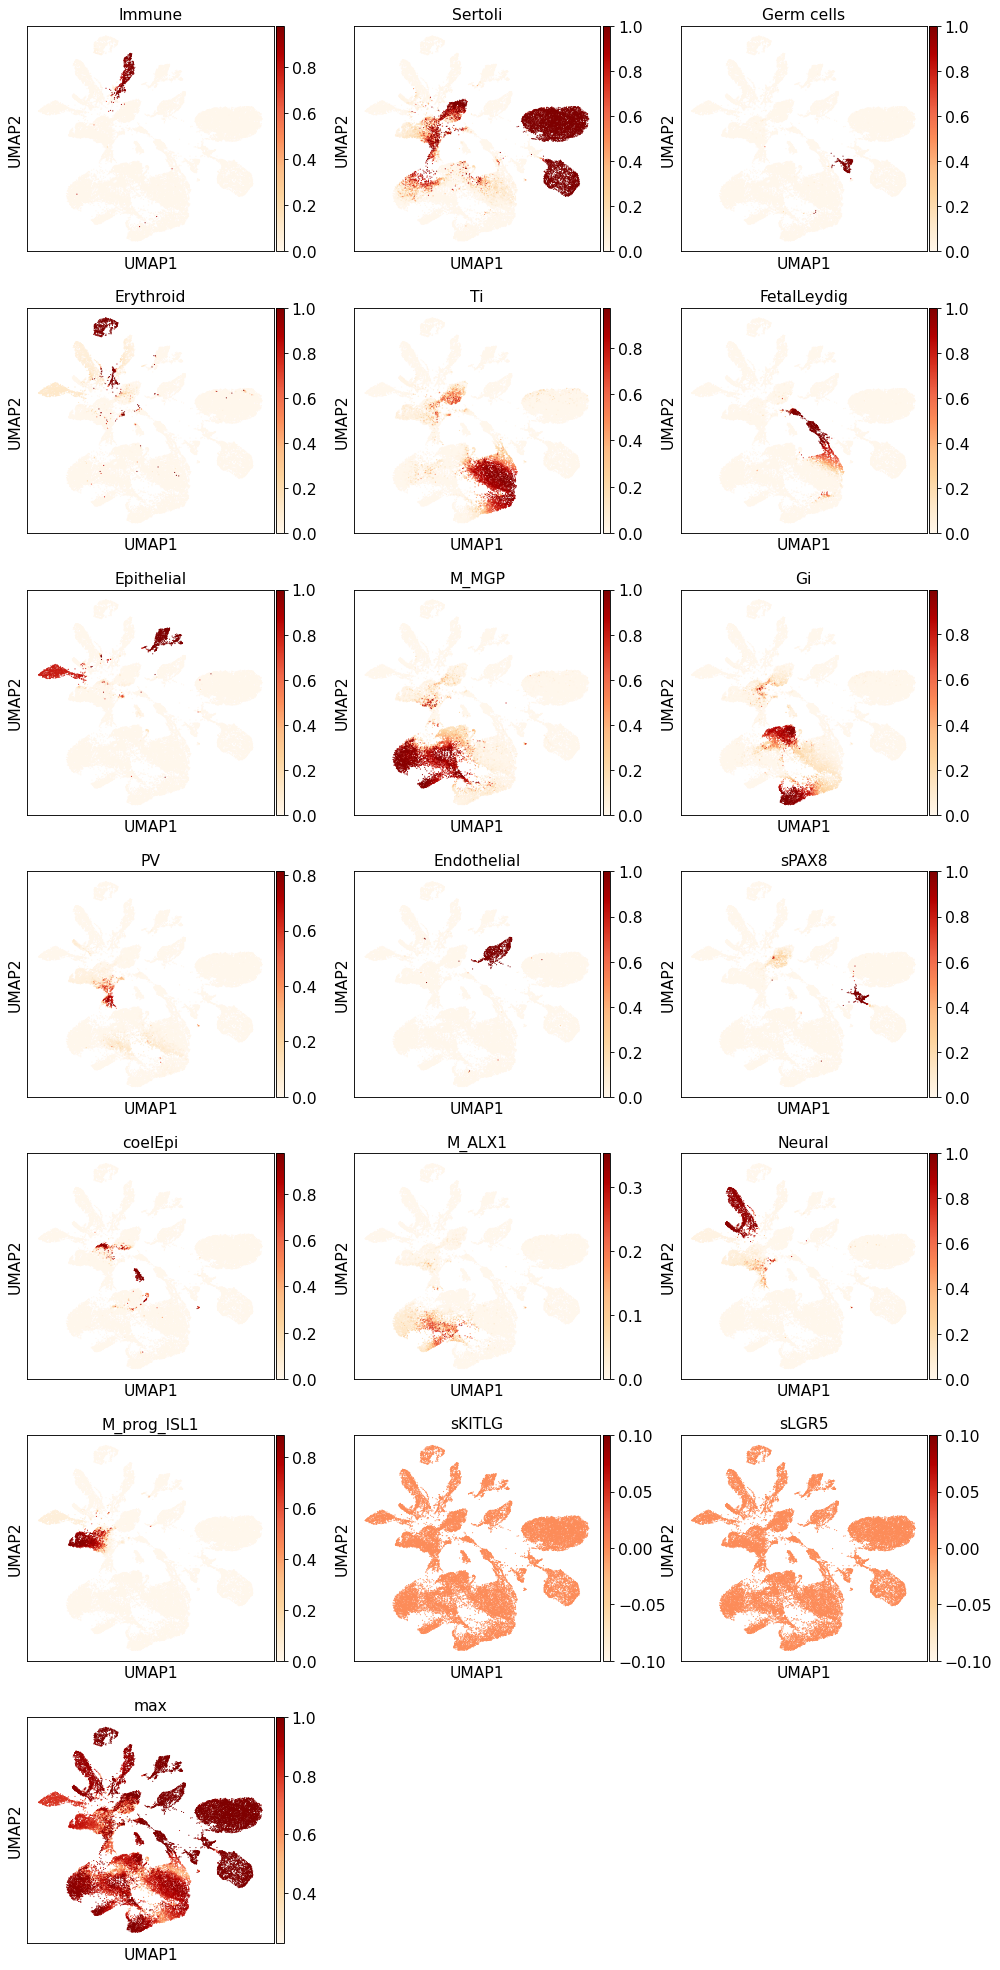

In [90]:
sc.pl.umap(gene_data, color = ['Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti',
       'FetalLeydig', 'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial',
       'sPAX8', 'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1',
       'sKITLG', 'sLGR5', 'max'], ncols = 3, color_map = 'OrRd', save = "_males_probs_noharmony.pdf")

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [56]:
gene_data.X

array([[64., 51., 51., ..., 47., 23., 81.],
       [60., 43., 43., ..., 48., 23., 74.],
       [59., 46., 46., ..., 45., 24., 71.],
       ...,
       [31., 12., 12., ..., 23.,  8., 50.],
       [47., 39., 39., ..., 48., 44., 68.],
       [42., 35., 35., ..., 46., 43., 67.]], dtype=float32)

In [57]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([49.679035, 49.408348, 49.059093, ..., 46.068806, 47.79106 ,
       47.436543], dtype=float32)

In [58]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

,mean_gene_activity
01-AAACGAAAGCTGAGGT-1,49.679035
01-AAACGAACAATCATCG-1,49.408348
01-AAACTCGTCACCCGGA-1,49.059093
01-AAACTGCCAAGGGTAC-1,48.135727
01-AAACTGCGTGAATGTA-1,46.810040


In [59]:
gene_data.obs['mean_gene_activity'] = means

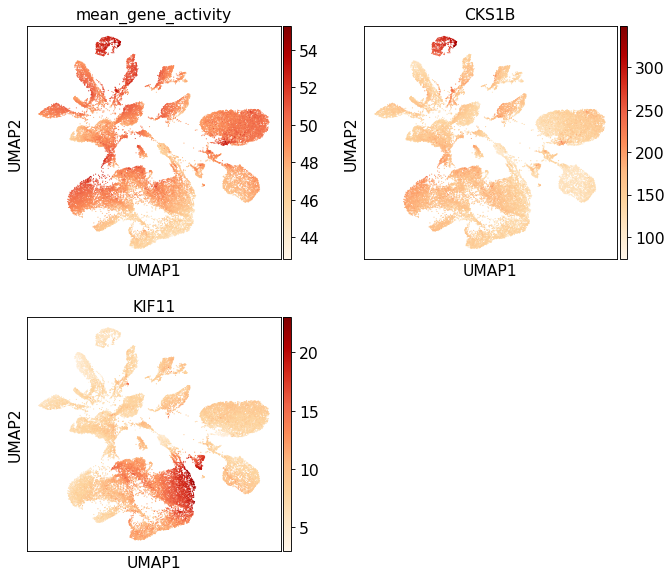

In [60]:
sc.pl.umap(gene_data, color = ['mean_gene_activity', 'CKS1B', 'KIF11'], ncols = 2, color_map = "OrRd")

In [61]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'FEN1', 'MCM2', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2', 'NASP', 'WDR76', 'SLBP', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
['BIRC5', 'TPX2', 'NDC80', 'NUF2', 'CKS1B', 'CENPF', 'TACC3', 'FAM64A', 'CKAP2L', 'BUB1', 'KIF11', 'TUBB4B', 'GTSE1', 'HJURP', 'HN1', 'TTK', 'KIF2C', 'RANGAP1', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']


In [62]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [63]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [91]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

**Save the predicted annotations to the peaks anndata object for ATAC**

In [92]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 30276 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'Sertoli_WFDC2', 'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'


In [93]:
for pred in predicted_probabilities.columns: 
    print(pred)
    adata.obs[pred] = predicted_probabilities[pred]

Immune
Sertoli
Germ cells
Erythroid
Ti
FetalLeydig
Epithelial
M_MGP
Gi
PV
Endothelial
sPAX8
coelEpi
M_ALX1
Neural
M_prog_ISL1
sKITLG
sLGR5
max


In [94]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

#### Visualize position in the manifold of dual ATAC samples

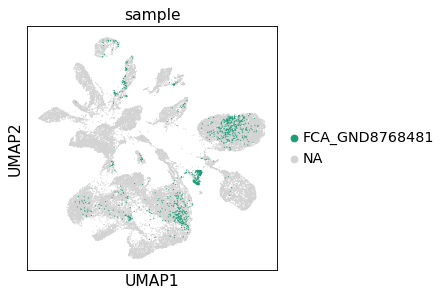

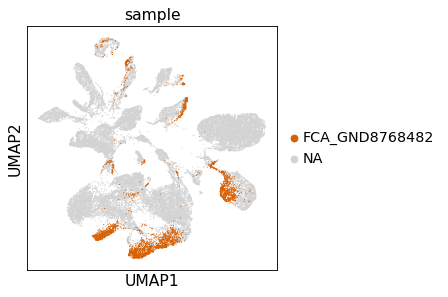

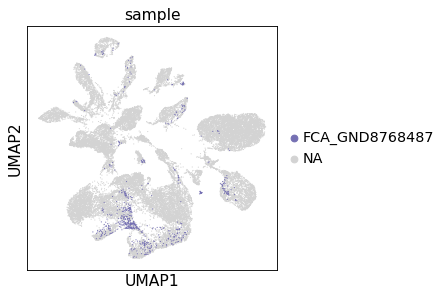

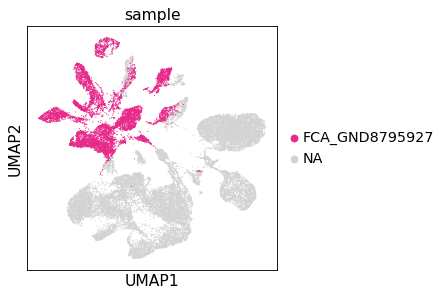

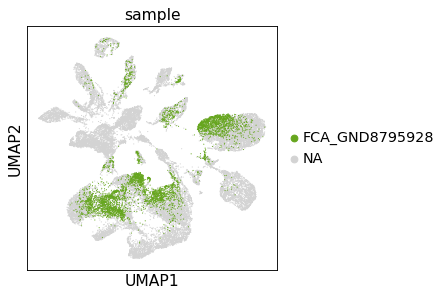

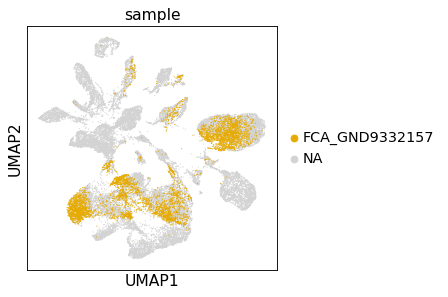

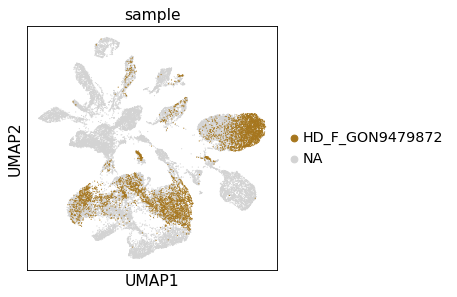

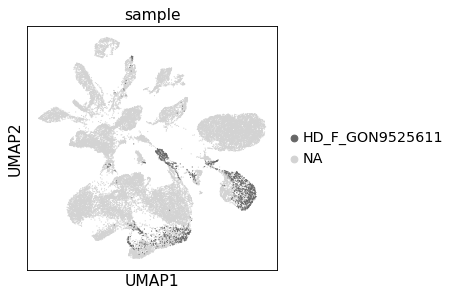

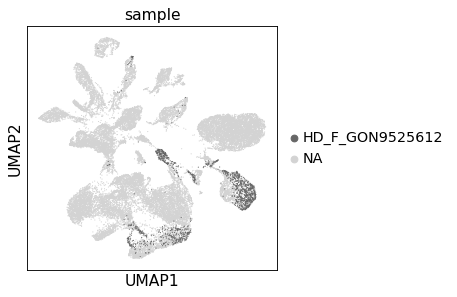

In [95]:
for sample in np.unique(adata.obs['sample']):
    sc.pl.umap(adata, color = 'sample', groups = sample, palette = 'Dark2', save = sample + ".pdf")

#### Integrate with Harmony

In [96]:
# Extract PCA matrix and batch array
n_pcs = 28
pca = adata.obsm['X_cistopic_28'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [97]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=1, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [98]:
# Add harmony values to the anndata object
adata.obsm['X_harmony'] = hem.values

In [99]:
sc.pp.neighbors(adata, use_rep= 'X_harmony', random_state=1234)
sc.tl.umap(adata)

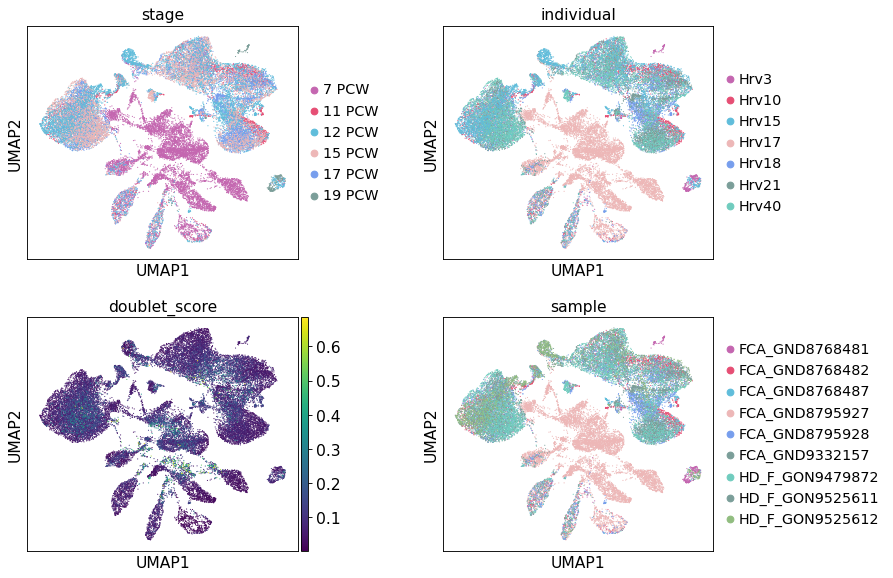

In [100]:
sc.pl.umap(adata, color = ['stage', 'individual', 'doublet_score', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "_harmony_metadata.pdf")

#### Clustering

In [102]:
gonads_colors = ['#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb']

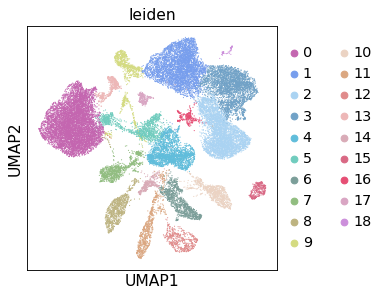

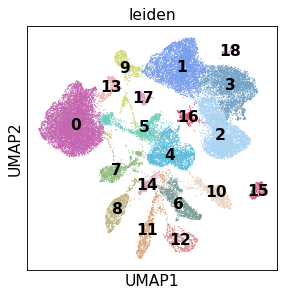

In [105]:
sc.tl.leiden(adata, resolution=0.4, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf', palette = gonads_colors)

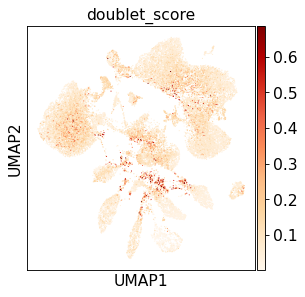

In [106]:
sc.pl.umap(adata, color = ['doublet_score'], color_map = 'OrRd')

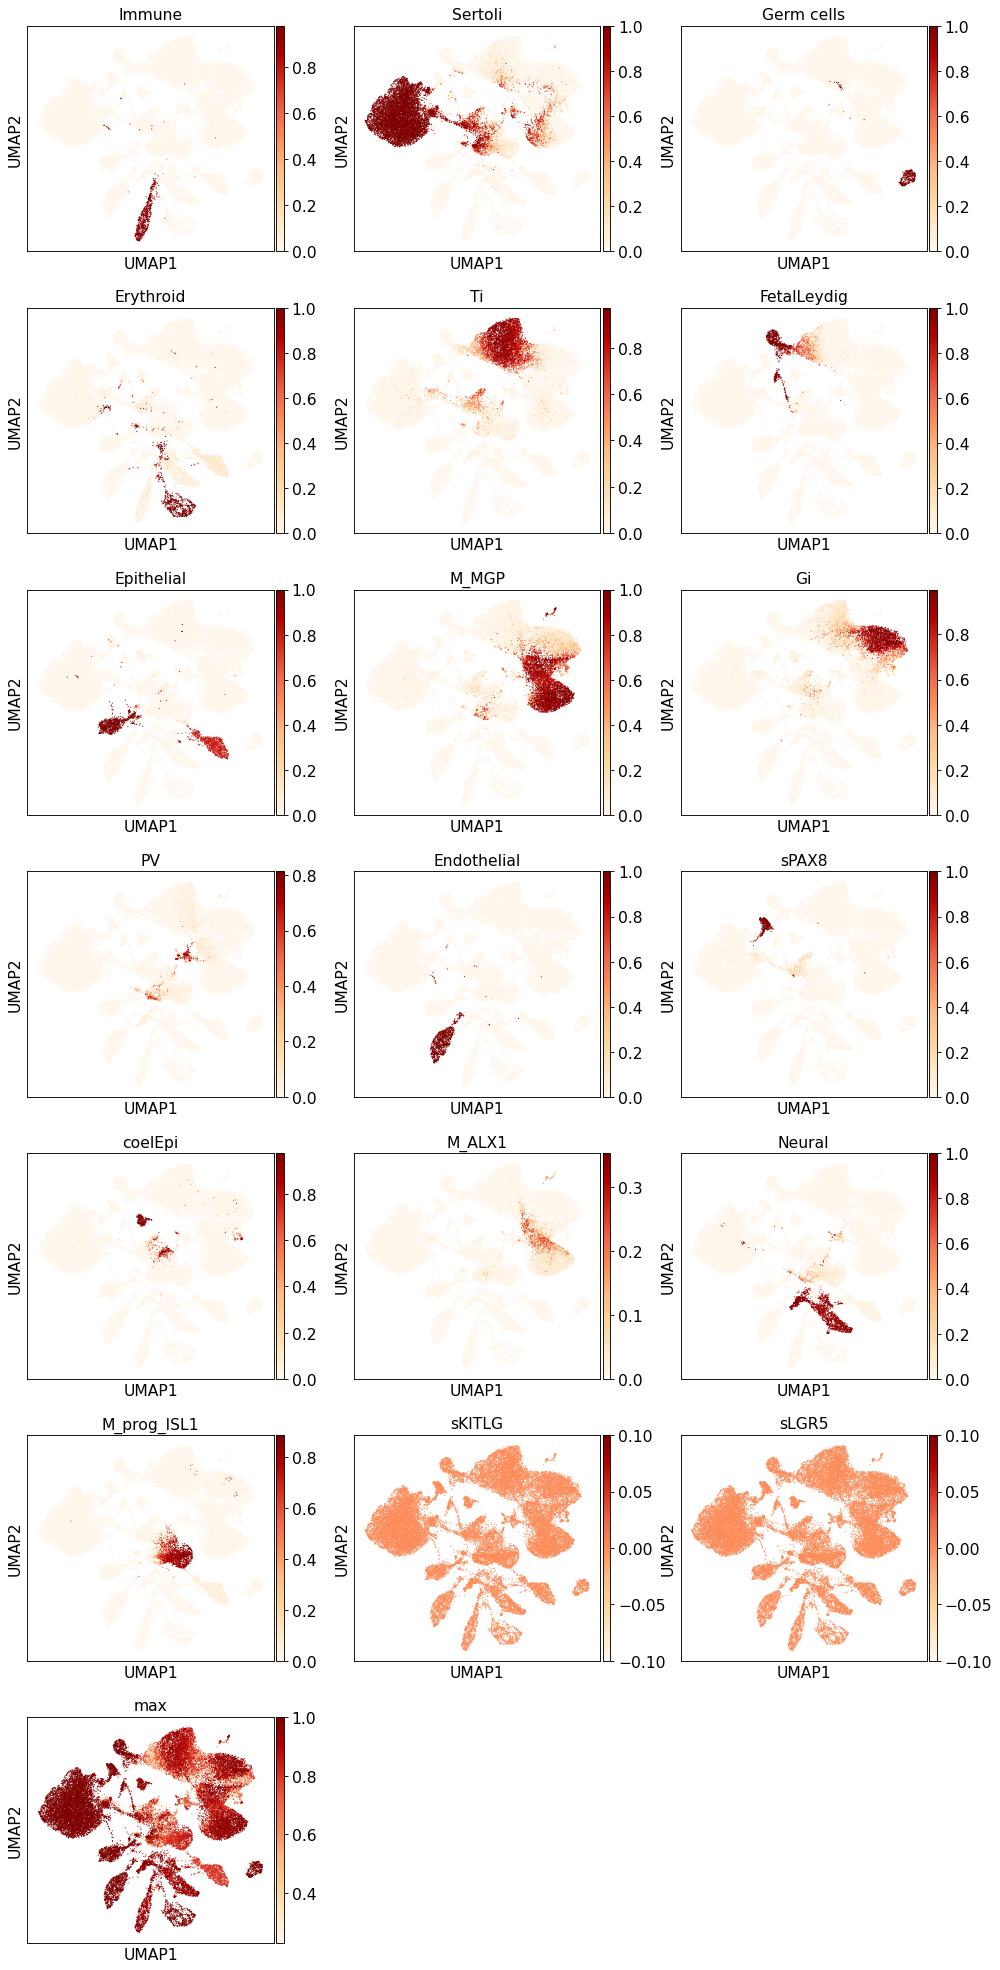

In [107]:
sc.pl.umap(adata, color = ['Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti',
       'FetalLeydig', 'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial',
       'sPAX8', 'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1',
       'sKITLG', 'sLGR5', 'max'], ncols = 3, color_map = 'OrRd', save = "_males_probs_harmony.pdf")

#### Matrixplot of label transfer predictions vs leiden clusters

In [10]:
sc.set_figure_params(scanpy=True, dpi=400, dpi_save=500, frameon=True, vector_friendly=True, transparent=True)

In [23]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories(['Germ cells',
                                                 'coelEpi',  'sPAX8',  'Sertoli',
                                                 'FetalLeydig', 'Ti',  'Gi', 
                                                 'M_prog_ISL1', 'M_MGP',
                                                 'PV','Epithelial', 'Endothelial', 'Immune',  'Erythroid', 'Neural'])

In [24]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage',
       'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'Immune',
       'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial',
       'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'Sertoli_WFDC2', 'coelEpi',
       'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5', 'max',
       'cell_type'],
      dtype='object')

In [25]:
matrix = adata.obs[['Immune',
       'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial',
       'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'coelEpi',
       'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5']].values
matrix.shape

(30276, 18)

In [26]:
plotting_obs = adata.obs[['leiden', 'cell_type']]
plotting_obs.shape

(30276, 2)

In [27]:
plotting_probs = ['Immune',
       'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial',
       'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'coelEpi',
       'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5']
plotting_var_dict = {'probs' : plotting_probs, 'random_string' : [str(i) for i in range(18)]}
plotting_var = pd.DataFrame(plotting_var_dict)
plotting_var = plotting_var.set_index('probs')
plotting_var.head()
plotting_var.shape

(18, 1)

In [28]:
plotting_adata = anndata.AnnData(X = matrix, obs = plotting_obs, var = plotting_var)
plotting_adata

AnnData object with n_obs × n_vars = 30276 × 18
    obs: 'leiden', 'cell_type'
    var: 'random_string'

In [30]:
ordered_probs = ['Germ cells',
                     'coelEpi',  'sPAX8',  'Sertoli',
                'FetalLeydig', 'Ti',  'Gi', 
                    'M_prog_ISL1', 'M_MGP',
            'PV','Epithelial', 'Endothelial', 'Immune',  'Erythroid', 'Neural', 'M_ALX1', 'sKITLG', 'sLGR5'
         
       ]

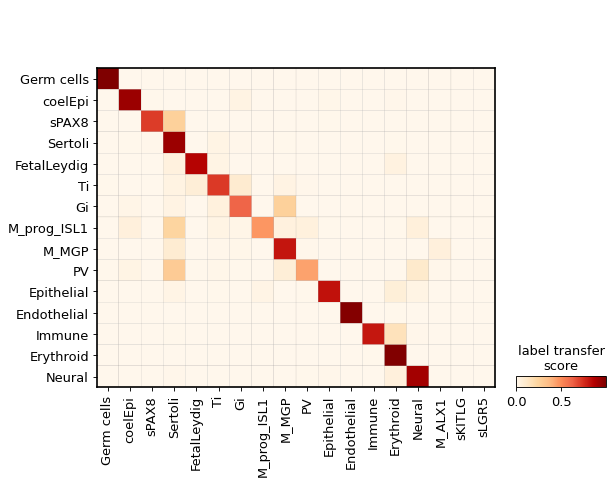

In [45]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot_celltype.pdf', colorbar_title = "label transfer\nscore", 
                title = " ")

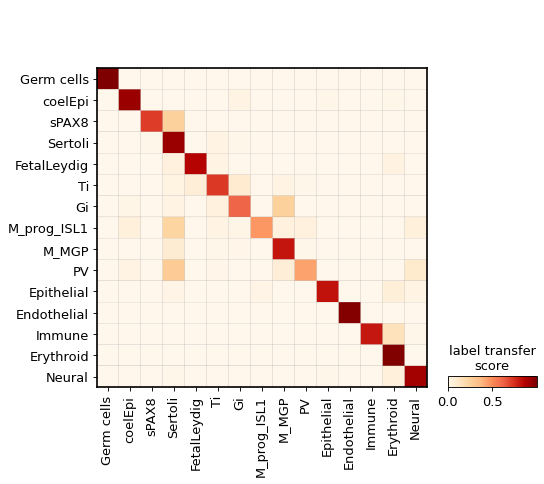

In [44]:
ordered_probs_present = ['Germ cells',
                     'coelEpi',  'sPAX8',  'Sertoli',
                'FetalLeydig', 'Ti',  'Gi', 
                    'M_prog_ISL1', 'M_MGP',
            'PV','Epithelial', 'Endothelial', 'Immune',  'Erythroid', 'Neural', 
         
       ]

sc.pl.matrixplot(plotting_adata, var_names = ordered_probs_present, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot_celltype_present.pdf', colorbar_title = "label transfer\nscore", 
                title = " ")

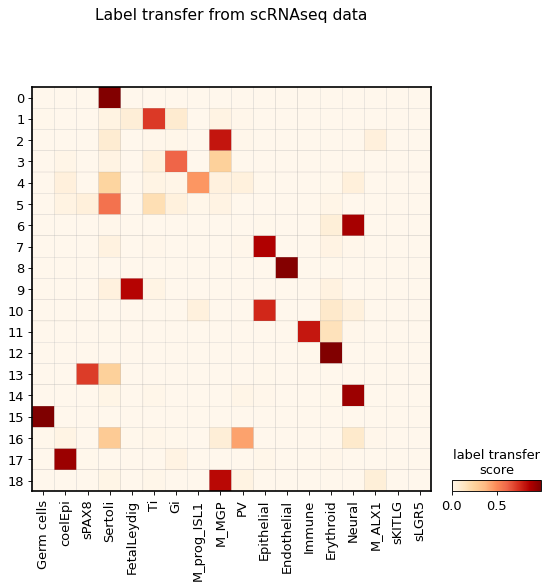

In [46]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'leiden', cmap = 'OrRd',
                  save = '_matrixplot_leiden.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

### Import annotations from dualRNA 

In [84]:
#annotations_dualRNA_female = pd.read_csv("/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_female_Hrv39_scmap_predictions_highRes.csv", index_col = 0)
annotations_dualRNA = pd.read_csv("/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_male_Hrv15.csv", index_col = 0)
#annotations_dualRNA = annotations_dualRNA_female.append(annotations_dualRNA_male)
annotations_dualRNA.head()

,n_genes,sample,donor,Library_ATAC Library_RNA iRods_path,percent_mito,n_counts,batch,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,leiden,clusters
HD_F_GON9525419_AAACAGCCACCTCAGG,4816,HD_F_GON9525419,Hrv15,HD_F_GON9525611 HD_F_GON9525419 ...,0.000665,10430.0,0,0.070248,0.145821,0.607078,0.764257,1.0,False,2,FetalLeydig
HD_F_GON9525419_AAACATGCAGGCTAGA,4581,HD_F_GON9525419,Hrv15,HD_F_GON9525611 HD_F_GON9525419 ...,0.000544,12520.0,0,0.140127,0.120690,0.309535,0.764257,1.0,False,0,Sertoli
HD_F_GON9525419_AAACCAACATACTCCT,1754,HD_F_GON9525419,Hrv15,HD_F_GON9525611 HD_F_GON9525419 ...,0.000000,2880.0,0,0.050967,0.050967,-0.515946,0.764257,1.0,False,2,FetalLeydig
HD_F_GON9525419_AAACCAACATGGTTAT,1880,HD_F_GON9525419,Hrv15,HD_F_GON9525611 HD_F_GON9525419 ...,0.000713,2486.0,0,0.129909,0.151515,0.674491,0.764257,1.0,False,0,Sertoli
HD_F_GON9525419_AAACCGAAGCGTGCAC,3804,HD_F_GON9525419,Hrv15,HD_F_GON9525611 HD_F_GON9525419 ...,0.000357,7663.0,0,0.151515,0.164286,0.825687,0.764257,1.0,False,0,Sertoli


In [85]:
adata.obs[['code', 'sample']].value_counts()

code  sample         
04    FCA_GND8795927     8302
06    HD_F_GON9479872    5193
07    FCA_GND9332157     5143
05    FCA_GND8795928     4372
02    FCA_GND8768482     2822
09    HD_F_GON9525612    1359
08    HD_F_GON9525611    1324
01    FCA_GND8768481     1061
03    FCA_GND8768487      700
dtype: int64

In [86]:
annotations_dualRNA.index = [i.replace("HD_F_GON9525419_", "08-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i.replace("HD_F_GON9525420_", "09-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i + "-1" for i in annotations_dualRNA.index]

In [87]:
annotations_dualRNA['clusters'].value_counts(dropna = False)

Sertoli                    1177
Ti                          617
FetalLeydig                 391
Mesenchymal_lowQC           227
Mesenchymal_GATA2_NR2F1     152
Sertoli_lowQC                74
Germ cells                   70
Epi_or_PAX8                  58
Immune                       36
Endothelial                  12
PV                            8
Name: clusters, dtype: int64

In [88]:
annotations_dualRNA['clusters'] = annotations_dualRNA['clusters'].astype("category")
annotations_dualRNA['clusters'] = annotations_dualRNA['clusters'].cat.remove_categories(['Mesenchymal_lowQC', 'Sertoli_lowQC'], inplace = False)
annotations_dualRNA['clusters'].value_counts(dropna = False)

Sertoli                    1177
Ti                          617
FetalLeydig                 391
NaN                         301
Mesenchymal_GATA2_NR2F1     152
Germ cells                   70
Epi_or_PAX8                  58
Immune                       36
Endothelial                  12
PV                            8
Name: clusters, dtype: int64

In [89]:
renamed = {'Sertoli' : 'Sertoli', 'FetalLeydig' : 'FetalLeydig', 'Ti' : 'Ti',
          'Germ cells' : 'Germ cells', 'Immune' : 'Immune',  'PV' : 'PV',
         'Epi_or_PAX8' : 'sPAX8', 'Endothelial' : 'Endothelial', 'Mesenchymal_GATA2_NR2F1' : 'Mesenchymal_GATA2_NR2F1'}
annotations_dualRNA['clusters_renamed'] = annotations_dualRNA['clusters'].map(renamed)

In [90]:
annotations_dualRNA['clusters_renamed'].value_counts()

Sertoli                    1177
Ti                          617
FetalLeydig                 391
Mesenchymal_GATA2_NR2F1     152
Germ cells                   70
sPAX8                        58
Immune                       36
Endothelial                  12
PV                            8
Name: clusters_renamed, dtype: int64

In [91]:
dualRNA_mapping = annotations_dualRNA['clusters_renamed'].to_dict()
adata.obs['dualRNA_label'] = adata.obs_names.map(dualRNA_mapping)
adata.obs['dualRNA_label'].value_counts(dropna = False)

NaN                        27880
Sertoli                     1144
Ti                           551
FetalLeydig                  381
Mesenchymal_GATA2_NR2F1      151
Germ cells                    59
sPAX8                         57
Immune                        35
Endothelial                   10
PV                             8
Name: dualRNA_label, dtype: int64

In [92]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].astype(str)
adata.obs['dualRNA_label'] = ["scATACseq_only"  if i == "nan" else i for i in adata.obs['dualRNA_label']]

In [93]:
adata.obs['dualRNA_label'].value_counts(dropna = False)

scATACseq_only             27880
Sertoli                     1144
Ti                           551
FetalLeydig                  381
Mesenchymal_GATA2_NR2F1      151
Germ cells                    59
sPAX8                         57
Immune                        35
Endothelial                   10
PV                             8
Name: dualRNA_label, dtype: int64

In [94]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].astype("category")
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].cat.reorder_categories([
     'Germ cells', 'sPAX8', 'Sertoli', 'FetalLeydig',
                'Ti', 'Mesenchymal_GATA2_NR2F1',  'PV','Endothelial',
                'Immune', 
                 'scATACseq_only'])

In [107]:
new_palette = ['#ff0000', # germs
                   '#4b944a', # sup
                  '#779eed', '#71a2c7', '#60bddb',  '#f5eecb', 
                  '#ffc266',  '#e36a1e',  '#ffb485', "#e0e0e0"]

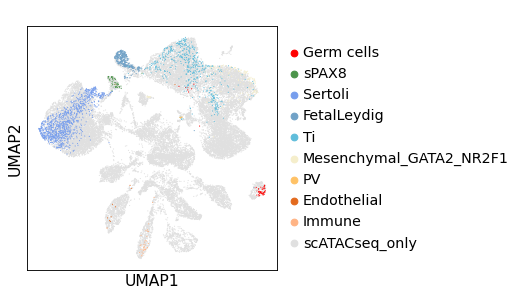

In [108]:
sc.pl.umap(adata, color = "dualRNA_label", save = "_dual_males.pdf", palette = new_palette, 
          title = " ")

In [13]:
# Transform the stage variable in numeric to plot the PCW as a gradient
pcws_dict = {'11 PCW' : 11, '12 PCW' : 12, '13 PCW' : 13, '14 PCW' : 14, '15 PCW' : 15, '17 PCW' : 17,
       '18 PCW' : 18, '19 PCW' : 19, '21 PCW' : 21, '7 PCW' : 7, '8 PCW' : 8, '9 PCW' : 9}
adata.obs['stage_numeric'] = adata.obs['stage'].map(pcws_dict)
adata.obs['stage_numeric'].value_counts(dropna = False)
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(float)

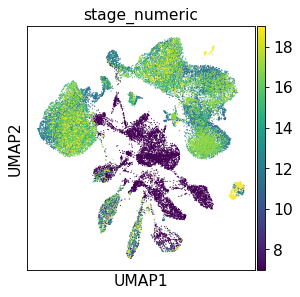

In [14]:
sc.pl.umap(adata, color='stage_numeric',legend_fontsize = 'medium', 
           legend_fontweight = 'medium', color_map = 'viridis', 
           save='_males_stage.pdf')

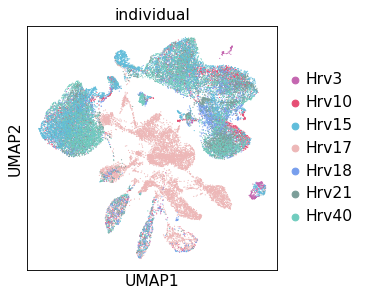

In [12]:
sc.pl.umap(adata, color='individual',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_males_individual.pdf', palette = gonads_colors)

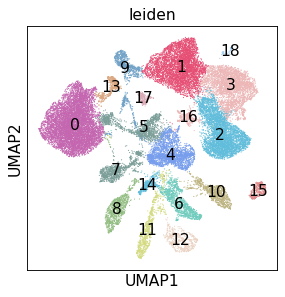

In [15]:
sc.pl.umap(adata, color='leiden',legend_loc='on data', legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_males_clustering_clusnumbers.pdf', palette = gonads_colors)

#### Annotated cells based on label transfer and dual RNA

In [118]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage',
       'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'Immune',
       'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial',
       'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'Sertoli_WFDC2', 'coelEpi',
       'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5', 'max'],
      dtype='object')

In [119]:
cell_type = {'0' : 'Sertoli', '1' : 'Ti', '2' : 'M_MGP', '3' : 'Gi', '4' : 'M_prog_ISL1',
            '5' : 'Sertoli', '6' : 'Neural', '7' : 'Epithelial', '8' : 'Endothelial', 
            '9' : 'FetalLeydig', '10' : 'Epithelial', '11' : 'Immune', '12' : 'Erythroid', 
            '13' : 'sPAX8', '14' : 'Neural', '15' : 'Germ cells', '16' : 'PV', 
            '17' : 'coelEpi', '18' : 'M_MGP'}
adata.obs['cell_type'] = adata.obs['leiden'].map(cell_type)
adata.obs['cell_type'].value_counts(dropna = False)

Sertoli        8580
Ti             4298
M_MGP          4044
Gi             3189
M_prog_ISL1    2387
Epithelial     1853
Neural         1522
Endothelial     894
FetalLeydig     890
Immune          824
Erythroid       508
sPAX8           438
Germ cells      323
PV              304
coelEpi         222
Name: cell_type, dtype: int64

In [48]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories([
    'Germ cells',
                                                 'coelEpi',  'sPAX8',  'Sertoli',
                                                 'FetalLeydig', 'Ti',  'Gi', 
                                                 'M_prog_ISL1', 'M_MGP',
                                                 'PV','Epithelial', 'Endothelial', 'Immune',  'Erythroid', 'Neural'
])

In [49]:
gonads_colors = ['#ff0000', # germs
                  '#366b36', '#4b944a', # sup
                  '#779eed', '#71a2c7', '#60bddb', '#94714e',
                  '#e6dec8', '#f5eecb', 
                  '#ffc266', '#d98200', '#e36a1e',  '#ffb485', '#ffd919',  # other
                   '#b5b5b5']

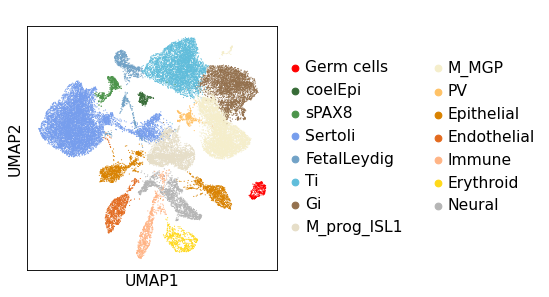

In [50]:
sc.pl.umap(adata, color = 'cell_type', palette = gonads_colors, 
           legend_fontsize = "medium", legend_fontweight = "medium", frameon = True, 
           title = " ",
           save = "_annotations_males.pdf", )

In [122]:
adata.write(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

In [10]:
adata = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

In [11]:
np.unique(adata.obs['individual'])

array(['Hrv10', 'Hrv15', 'Hrv17', 'Hrv18', 'Hrv21', 'Hrv3', 'Hrv40'],
      dtype=object)

In [132]:
adata.obs[['individual', 'sample', 'stage']].value_counts()

individual  sample           stage 
Hrv17       FCA_GND8795927   7 PCW     8302
Hrv40       HD_F_GON9479872  15 PCW    5193
Hrv21       FCA_GND9332157   17 PCW    5143
Hrv18       FCA_GND8795928   12 PCW    4372
Hrv10       FCA_GND8768482   11 PCW    2822
Hrv15       HD_F_GON9525612  12 PCW    1359
            HD_F_GON9525611  12 PCW    1324
Hrv3        FCA_GND8768481   19 PCW    1061
Hrv15       FCA_GND8768487   12 PCW     700
dtype: int64

In [134]:
adata.obs[['individual', 'stage']].value_counts()

individual  stage 
Hrv17       7 PCW     8302
Hrv40       15 PCW    5193
Hrv21       17 PCW    5143
Hrv18       12 PCW    4372
Hrv15       12 PCW    3383
Hrv10       11 PCW    2822
Hrv3        19 PCW    1061
dtype: int64

In [133]:
adata.shape

(30276, 232562)

#### Save adata.var as input for CICERo

In [13]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]

In [14]:
adata.var = adata.var.set_index('peaks_formatted')
adata.var.to_csv(outdir + experiment_prefix + "adata_var_for_cicero.csv")

#### End of notebook